In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import random 

from work import handler
from work import casestudy
from work import storm_tracker

from tempest.plots.hist import simple_hist
settings_path = 'settings/sam3d.yaml'

In [7]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.43 seconds


In [11]:
import os 

duration_min = 12
surfmaxkm2_min = 50000
region_latmin, region_latmax, region_lonmin, region_lonmax = 4, 25, -18, 25
save_storms_path = st.settings["DIR_DATA_OUT"] + f"save_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"

# os.remove(save_storms_path)

if not os.path.exists(save_storms_path): 
    storms = xr.open_dataset(st.file_storms)
    
    # Filter based on duration and surface area
    storms = storms.where(storms.INT_duration > duration_min, drop=True)  # 1min
    storms = storms.where(storms.INT_surfmaxkm2_241K > surfmaxkm2_min, drop=True)
    
    # Apply latitude and longitude constraints
    storms = storms.where((storms.INT_latmin >= region_latmin) & (storms.INT_latmax <= region_latmax), drop=True)
    if region_lonmin>=0 : 
        storms = storms.where((storms.INT_lonmin >= region_lonmin) & (storms.INT_lonmax <= region_lonmax), drop=True)
    elif region_lonmin<0:
        storms = storms.where((storms.INT_lonmin >= 360+region_lonmin) | (storms.INT_lonmin <= region_lonmax), drop=True)
    
    # Save the filtered storms data
    storms.to_netcdf(save_storms_path)
    storms.close()
else: 
    storms = xr.open_dataset(save_storms_path)

In [12]:
storms

<xarray.Dataset>
Dimensions:              (DCS_number: 246, time: 911)
Coordinates:
  * DCS_number           (DCS_number) int64 153398 153400 ... 285587 286121
  * time                 (time) int64 817681 817682 817683 ... 818590 818591
Data variables: (12/53)
    INT_TbMin            (DCS_number) float64 ...
    INT_UTC_timeEnd      (DCS_number) float64 ...
    INT_UTC_timeInit     (DCS_number) float64 ...
    INT_classif          (DCS_number) float64 ...
    INT_classif_JIRAK    (DCS_number) float64 ...
    INT_classif_MADDOX   (DCS_number) float64 ...
    ...                   ...
    LC_tbavg_241K        (DCS_number, time) float64 ...
    LC_tbmin             (DCS_number, time) float64 ...
    LC_velocity          (DCS_number, time) float64 ...
    LC_x                 (DCS_number, time) float64 ...
    LC_y                 (DCS_number, time) float64 ...
    QCgeo_IRimage        (DCS_number, time) float64 ...

In [13]:
## FileTracking is ft
ft = storms[[ 
    "INT_UTC_timeInit", "INT_UTC_timeEnd", "INT_duration", "INT_surfcumkm2_241K", "INT_velocityAvg", "INT_surfmaxkm2_241K", ## General characteristics
    "LC_lon", "LC_lat", "LC_UTC_time", "LC_ecc_241K", "LC_orientation_241K", "LC_surfkm2_241K", "LC_tb_90th", "LC_velocity" ## General characteristics
             ]]

to_drop = []
for iDCS in ft.DCS_number.values : 
    print(iDCS)
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = st.get_frame_data(ft, iDCS)
    # extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d)
    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)
    if t<2 or i_smax < 0:
        to_drop.append(iDCS)
ft = ft.drop_sel(DCS_number = to_drop)

153398
153400
153402
153463
153503
153506
153510
153512
153515
153556
153565
153607
153674
153686
153724
153736
153777
153805
153851
153858
153880
153893
153898
153958
153990
154094
154106
154121
154433
154447
154558
154586
154635
154654
154711
154988
155326
155713
156438
173892
173894
173905
173915
173919
173946
173982
174003
174008
174079
174118
174275
174345
174445
174486
174581
174583
174675
174986
175097
175105
175138
175176
175225
175350
175396
175587
175595
176589
181276
194715
194767
194777
194801
194823
194831
194851
194859
194862
194870
194947
194956
195013
195014
195074
195087
195105
195205
195219
195256
195280
195288
195322
195615
196177
196504
196637
197358
197388
198425
215708
215713
215801
215804
215940
215950
215975
215993
215999
216019
216107
216111
216118
216125
216154
216163
216551
216715
216904
217203
217483
217794
217805
217866
217884
217979
218289
218429
218800
238362
238473
238476
238640
238653
238666
238714
238823
238859
238878
238904
238945
238977
239117
239149

In [14]:
test = xr.open_dataset("/bdd/DYAMOND/SAM-4km/OUT_3D/DYAMOND_9216x4608x74_7.5s_4km_4608_0000001440_PP.nc")
z_targets = [300, 2000, 4000, 8000, 12000]
z_indices = [np.abs(test.z.values - target).argmin() for target in z_targets]
z_all = test.z.values.copy()
z_tropo = z_all[:np.abs(test.z.values - 15000).argmin()+1] # L'alitude de la Troposphère est à 15000m à l'équateur max non ? utiliser les pressions ? 
print("z_shear index", z_indices)
print("len z_tropo", len(z_tropo))

p_targets = [975, 800, 600, 350, 200] #mbar or hPa
p_indices = [np.abs(test.p.values-target).argmin() for target in p_targets] ## Est ce que je dois être plus flexible sur l'extraction des coordonnées de pression ? 
                                                                            ## Je peux le faire en extrayant les vents puis interpolant sur ma grille régulière ! 
p_all = test.p.values.copy()
print("p       index", p_indices)
test.close()

z_shear index [6, 22, 29, 37, 45]
len z_tropo 52
p       index [6, 22, 30, 38, 45]


## 3d mode


In [18]:
## Valid times for 3d var are %6==0 
t=0
while t<4: 
    ft_3d = ft.sel(time=ft.time[(ft.time - st.i_t_start + cs.settings["TIME_RANGE"][0]) % 6 == 0])
    iDCS = random.choice(ft_3d.DCS_number.values)
    iDCS = 286121
    start, end, lons, lats, speeds, times, time_smax, i_smax, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d  = st.get_frame_data(ft, iDCS)
    extents, slices_lon, slices_lat = st.get_extents_slices(lons_3d, lats_3d, large_scale_frame_size = 1.5)


    times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]
    t = len(times_3d_conv)
    
print("times :" , times_3d)
print(start, time_smax, end)
print(t)

times : [1872. 1878. 1884. 1890. 1896. 1902.]
864 876 895
3


In [17]:
print(times_3d_conv)

[1872.0, 1878.0, 1884.0]


## extract Wind env all z per age (4%step)

In [37]:
tangeant_wind_env_by_age = np.full(fill_value = np.nan, shape=(len(z_tropo), 25))
normal_wind_env_by_age = np.full(fill_value = np.nan, shape=(len(z_tropo), 25))

i = 1

slice_lat, slice_lon, extent = slices_lat[i], slices_lon[i], extents[i] ## slices are correctly 3d ones

le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

u = hdlr.load_var(cs, "U", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).U[0]
v = hdlr.load_var(cs, "V", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).V[0]
w = hdlr.load_var(cs, "W", times_3d[i], z_idx = "L'altitude de la troposphère", sel_dict = le_dico_court).W[0]
seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)

##### DCS MATURATION TOTAL PROPAGATION #####
lon_smax, lat_smax = lons[i_smax], lats[i_smax]
lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
lons[0], lats[0], lon_propa, lat_propa #angles='xy', scale_units='xy'

norm_propa = np.sqrt(lon_propa**2 + lat_propa**2)    
u_propa, v_propa = lon_propa/norm_propa, lat_propa/norm_propa
mask = (seg != iDCS)
u_env_masked, v_env_masked = np.where(mask, u, np.nan), np.where(mask, v, np.nan)

tangeant_wind_env = u_env_masked * u_propa + v_env_masked * v_propa
normal_wind_env = -u_env_masked * v_propa + v_env_masked * u_propa

tangeant_wind_env_mean = np.nanmean(tangeant_wind_env)
normal_wind_env_mean = np.nanmean(normal_wind_env)

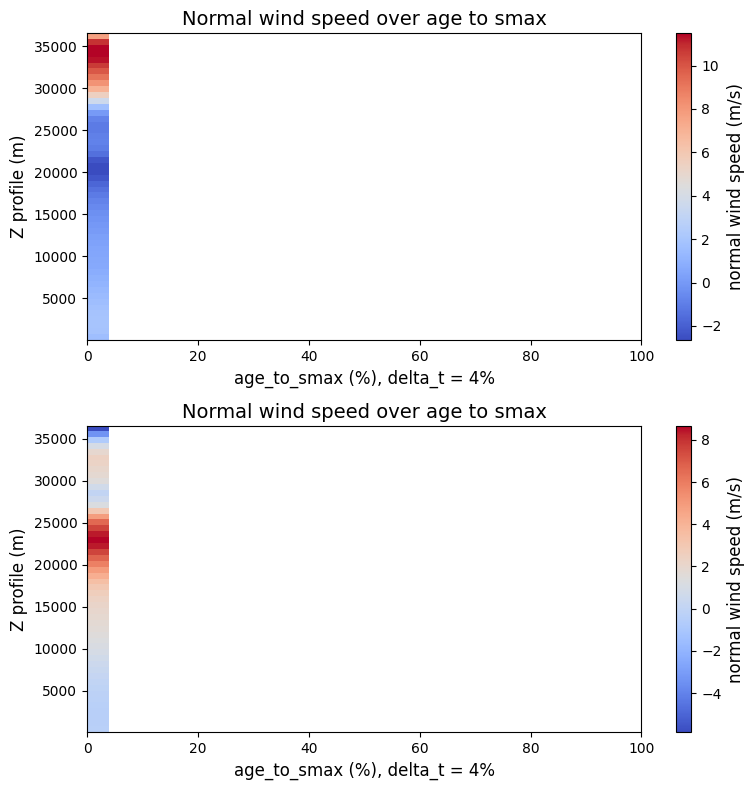

In [43]:
z_tangeant_wind_env_mean = np.nanmean(tangeant_wind_env, axis = (1,2))
z_normal_wind_env_mean   = np.nanmean(  normal_wind_env, axis = (1,2))
age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))

i_age = age_to_smax%4 # because 100/25 is 4  

tangeant_wind_env_by_age[:,i_age] = z_tangeant_wind_env_mean
normal_wind_env_by_age[:, i_age] = z_normal_wind_env_mean


def plot_wind_env_by_age(tangeant, normal, width = 8, height = 8):
  # Define your desired aspect ratio by controlling the figure size
  fig, axs = plt.subplots(2, 1, figsize=(width, height))  # Replace width and height with desired values
  for ax, arr in zip(axs, [tangeant, normal]):
    x_vals = np.linspace(0, 100, normal.shape[1])  # Adjust according to your data
    y_vals = np.array(z_all)  # Ensure z_all is a NumPy array of actual z-axis values (in meters)
      # Adjust according to your data

    cax = ax.imshow(arr, origin="lower", aspect='auto',
                    cmap='coolwarm',  # Replace 'coolwarm' with your preferred colormap
                    extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()])  # Custom x/y axis values

    # Add colorbar with label
    cbar = fig.colorbar(cax)
    cbar.set_label('normal wind speed (m/s)', fontsize=12)  # Replace with the appropriate label

    # Add labels and title
    ax.set_title('Normal wind speed over age to smax', fontsize=14)  
    ax.set_xlabel('age_to_smax (%), delta_t = 4%', fontsize=12)  
    ax.set_ylabel('Z profile (m)', fontsize=12)  
    # Customize axis limits if necessary
    ax.set_xlim([x_vals.min(), x_vals.max()])  # Adjust the x-axis limits as needed
    ax.set_ylim([y_vals.min(), y_vals.max()])  # Adjust the y-axis limits as needed
    plt.tight_layout()

plot_wind_env_by_age(tangeant_wind_env_by_age, normal_wind_env_by_age)


## Single level 

0.6671117 5.9716234
0.17267263 8.970966
-0.009200252 3.8230305
8.322614 -4.577852
6.24119 -10.525498
0.44796205 7.02021
0.3798004 9.090097
0.4060175 3.3595846
7.170792 -5.8832703
5.32938 -8.618394
-0.7114311 6.365894
-0.94206136 7.683444
0.3618405 3.3295844
7.2433157 -5.7517986
6.381107 -9.221644


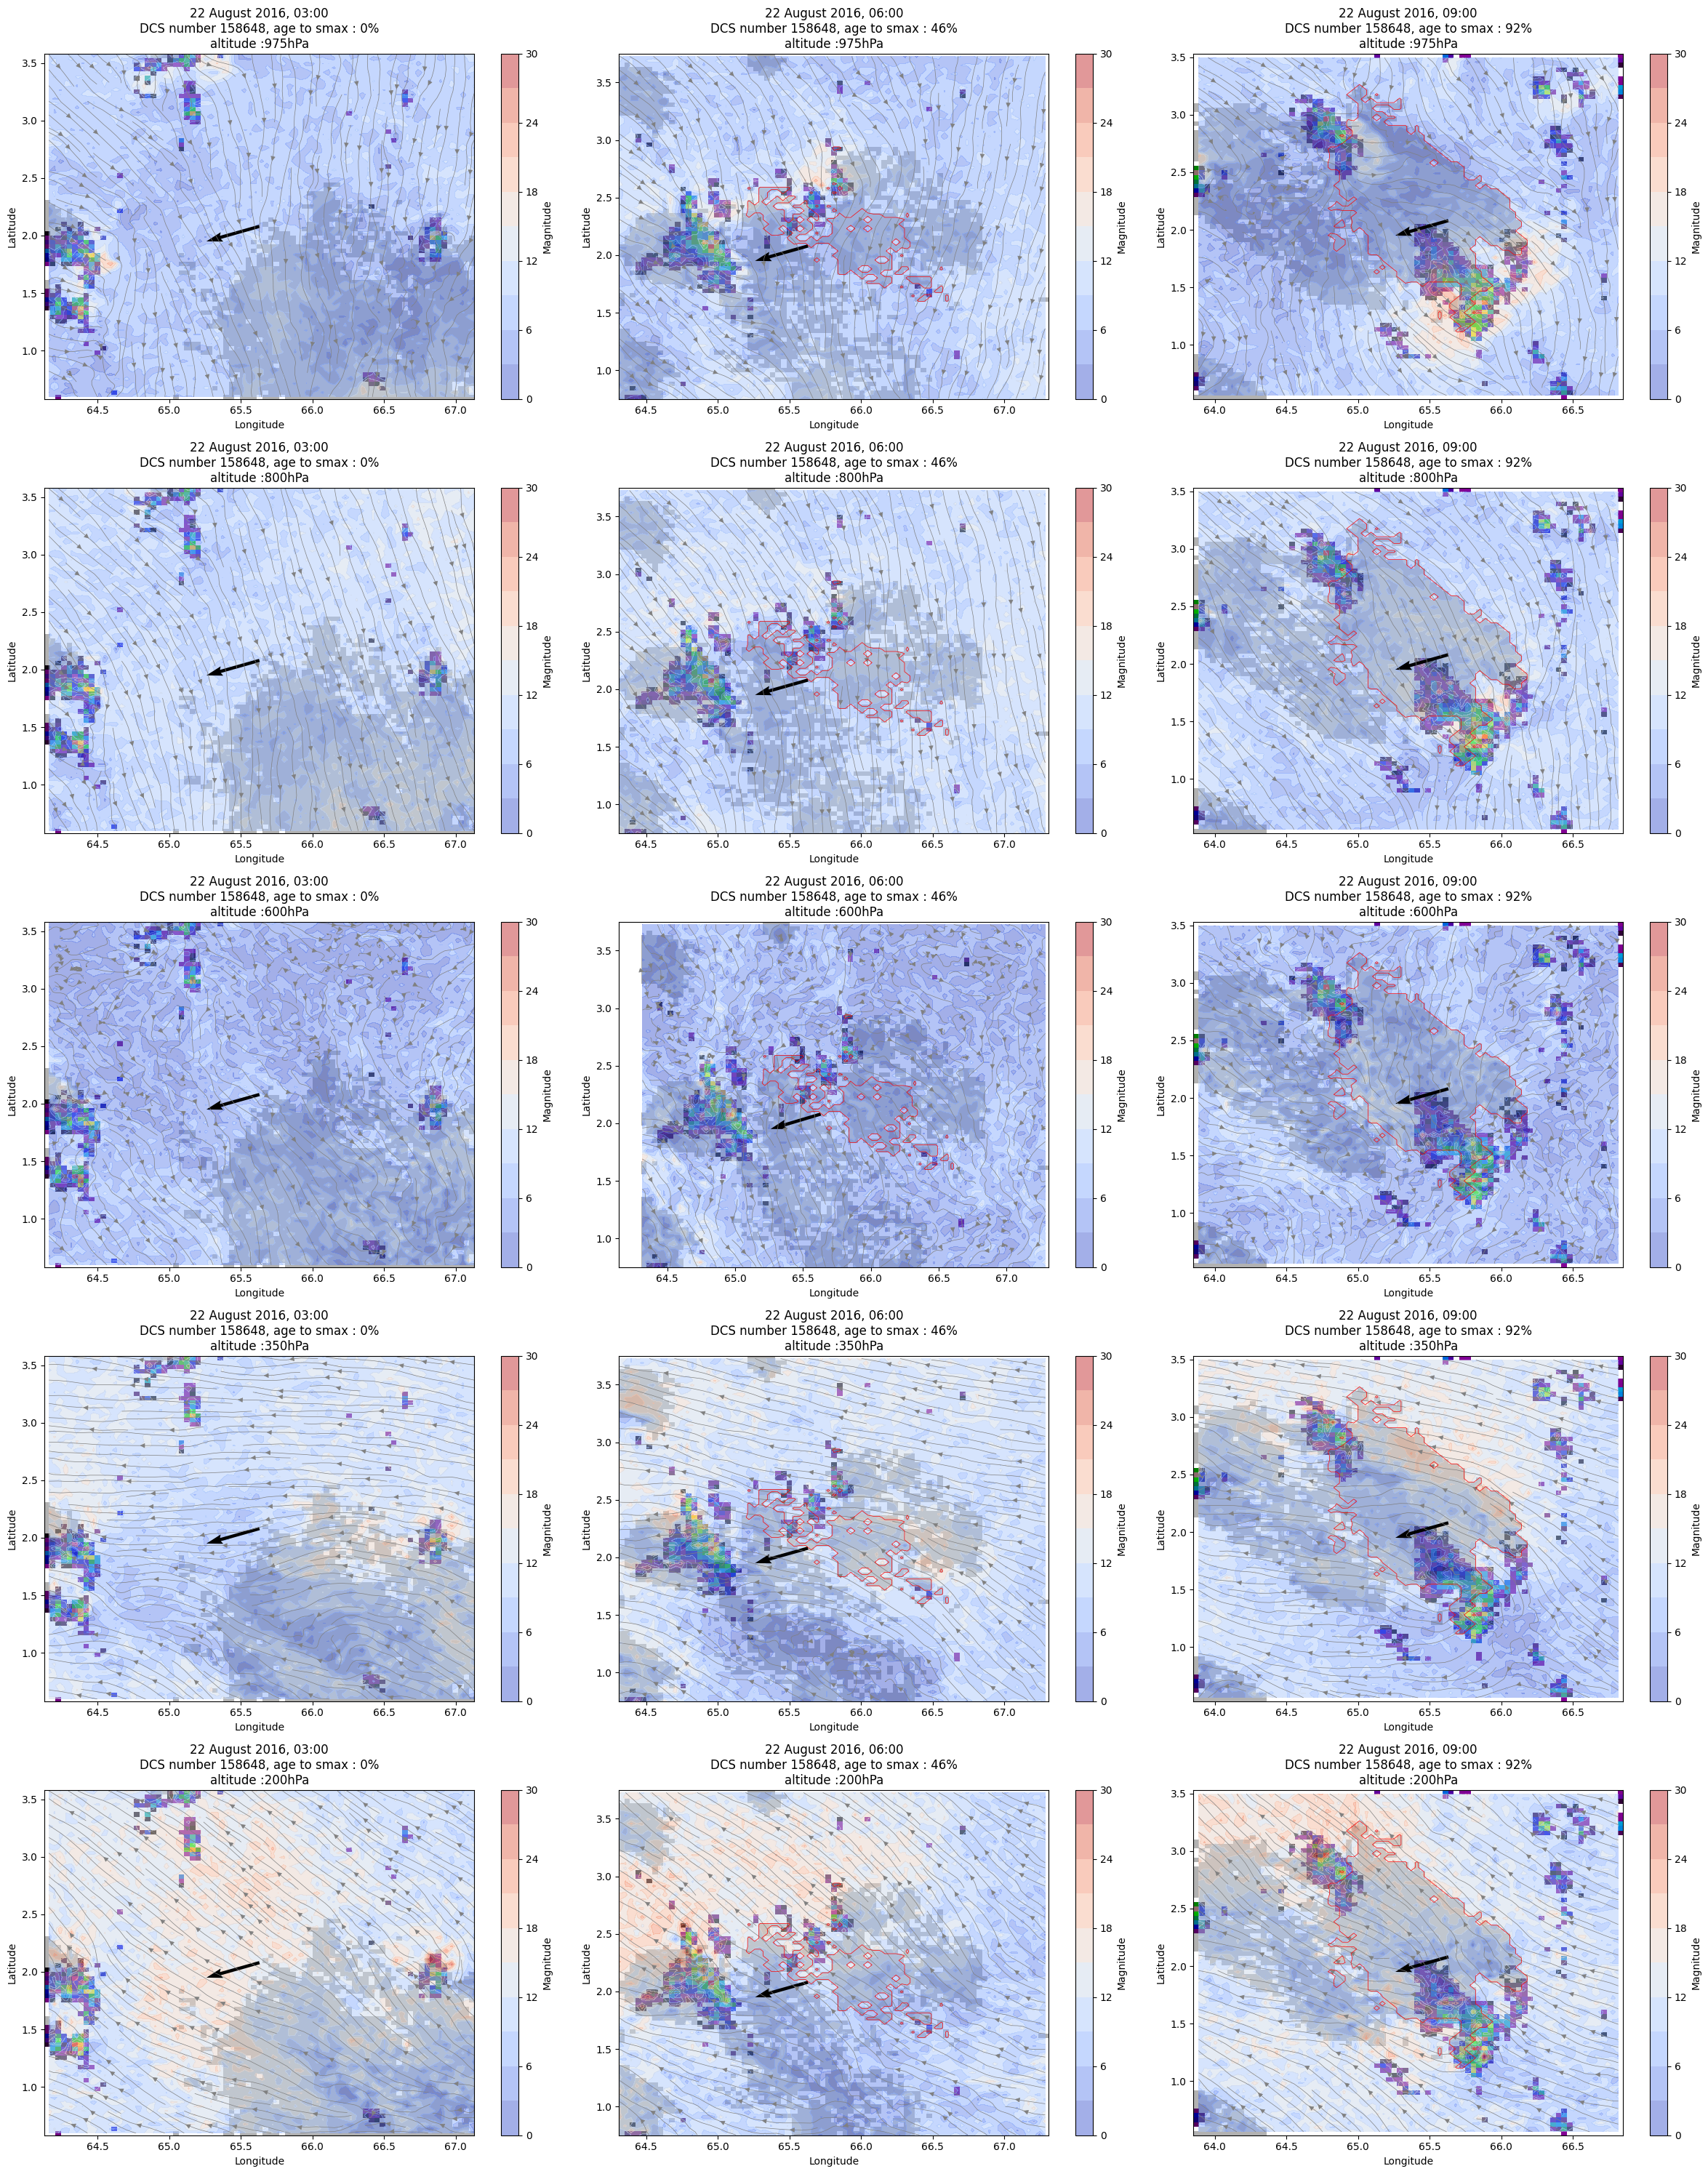

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def my_plot(ax, i, i_z):
    slice_lat, slice_lon, extent = slices_lat[i], slices_lon[i], extents[i]
    ##### DETAILS #####
    # ax = axs[i]
    colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    colors = [(1, 1, 1, 0), (0.0, 0.0, 0.0, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)
    prec_cmap =  plt.get_cmap("nipy_spectral")
    w_cmap = plt.get_cmap("viridis")
    prec_cmap.set_bad(color=(1, 1, 1, 0))  # I think that's useless but unsure the way maps are superimposed
    cmap.set_bad(color=(1, 1, 1, 0))  # Transparent for NaNs
    hodo_colors = ["blue", "orange", "green", "red", "purple"] ## en fait exactement l'inverse que Cui 2021...

    le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
    le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

    ##### WINDS #####
    z = int(z_indices[i_z])
    La_Couleur_De_L_hodographe = hodo_colors[i_z]
    u = hdlr.load_var(cs, "U", times_3d[i], z_idx = z, sel_dict = le_dico_court).U[0,0]
    v = hdlr.load_var(cs, "V", times_3d[i], z_idx = z, sel_dict = le_dico_court).V[0,0]  
    # w = hdlr.load_var(cs, "W", times_3d[i], z_idx = z, sel_dict = le_dico_court).W[0,0]
    


    #### REGULAR GRID LONLAT ####
    # We need a regular grid to use streamplot so we build one here
    lon, lat = u["lon"], v["lat"]
    new_lon, new_lat = np.linspace(lon.min(), lon.max(), len(lon)), np.linspace(lat.min(), lat.max(), len(lat))
    u_clean = u.interp(lon=new_lon, lat=new_lat)
    v_clean = v.interp(lon=new_lon, lat=new_lat)
    Lon_grid, Lat_grid = np.meshgrid(new_lon, new_lat)

    
    ##### WIND STREAMFUNCTION ####
    ax.streamplot(Lon_grid, Lat_grid, u_clean.values, v_clean.values, color='grey', linewidth=0.5, density=1.5)
    
    ##### WIND DIVERGENCE ####
    # dudx = np.gradient(u_clean.values, axis=1)  # derivative of u with respect to longitude (x)
    # dvdy = np.gradient(v_clean.values, axis=0)  # derivative of v with respect to latitude (y)
    # divergence = dudx + dvdy
    # div_plot = ax.contourf(Lon_grid, Lat_grid, divergence, levels = 10, cmap = 'viridis')
    # fig.colorbar(div_plot, ax=ax, label='Divergence')

    ##### WIND MAGNITUDE #####
    wind_magnitude = np.sqrt(u_clean.values**2 + v.values**2)
    wind_magn_plot = ax.contourf(Lon_grid, Lat_grid, wind_magnitude, levels = np.linspace(0,30,11), cmap = "coolwarm", alpha = 0.5)
    fig.colorbar(wind_magn_plot, ax=ax, label='Magnitude')

    # wind_contours = ax.contour(Lon_grid, Lat_grid, wind_magnitude, levels=1, colors=La_Couleur_De_L_hodographe, linewidths=0.8)
    # ax.clabel(wind_contours, inline=True, fontsize=10, fmt="%.2f")  # Adds labels to the contours
    # print(wind_contours.levels)

    ##### PREC #####
    prec = hdlr.load_var(cs, "Prec", times_3d[i], sel_dict = le_dico_court).sel(le_dico_court).values
    prec_masked = np.ma.masked_less_equal(prec, 3)
    ax.imshow(prec_masked, origin = 'lower', cmap = prec_cmap, interpolation='nearest', alpha = 1, extent = extent)

    ##### CLOUD MASK + CONTOUR ######
    seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype = float)
    output[nan_mask] = 0
    output[seg == iDCS] = 1
    ax.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid',extent = extent) #
    output[seg == iDCS] = 0.5
    ax.imshow(output, origin = 'lower', cmap=cmap, interpolation='nearest', alpha = 1, norm=mcolors.Normalize(vmin=0, vmax=1), extent = extent)

    ##### DCS SPEED AND TRAJECTORY #####
    # ax.plot(lons_3d[:i+1], lats_3d[:i+1], marker='o', color='grey', label='Trajectory Path', markersize=1)
    # if i != start and i!= end-1 : 
    #     # print("Le déplacement du centre de masse du système : ", np.sqrt(speed_lon_3d[i]**2 + speed_lat_3d[i]**2))
    #     ax.quiver(lons_3d[i], lats_3d[i], speed_lon_3d[i], speed_lat_3d[i], scale = 0.2/np.sqrt(speed_lon_3d[i]**2 + speed_lat_3d[i]**2)) #
    
    ##### DCS MATURATION TOTAL PROPAGATION #####
    lon_smax, lat_smax = lons[i_smax], lats[i_smax]
    lon_propa, lat_propa = lon_smax - lons[0], lat_smax - lats[0]
    ax.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')

    #### Compute Projected winds onto Total propagation #####
    norm_propa = np.sqrt(lon_propa**2 + lat_propa**2)    
    u_propa, v_propa = lon_propa/norm_propa, lat_propa/norm_propa
    mask = (seg != iDCS)
    u_env_masked, v_env_masked = np.where(mask, u, np.nan), np.where(mask, v, np.nan)

    tangeant_wind_env = u_env_masked * u_propa + v_env_masked * v_propa
    normal_wind_env = -u_env_masked * v_propa + v_env_masked * u_propa

    tangeant_wind_env_mean = np.nanmean(tangeant_wind_env)
    normal_wind_env_mean = np.nanmean(normal_wind_env)
    print(tangeant_wind_env_mean, normal_wind_env_mean)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('auto')

    age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))
    ax.set_title(f'{hdlr.i_t_to_nice_datetime(times_3d[i])}' +'\n'f"DCS number {iDCS}, age to smax : {age_to_smax}%"+"\n"+"altitude :"+f"{p_targets[i_z]}hPa", loc='center')   

    return ax, lon, lat, wind_magnitude, mask

t = len(times_3d_conv) #times_3d_conv
# Initialize figure and axis
fig, axs = plt.subplots(len(z_indices),t, figsize=(8*t, 30))
for i in range(t):
    for i_z in range(len(z_indices)):
        ax = axs[i_z, i]
        ax, lon, lat, uv_magn, mask= my_plot(ax, i, i_z)


plt.tight_layout()

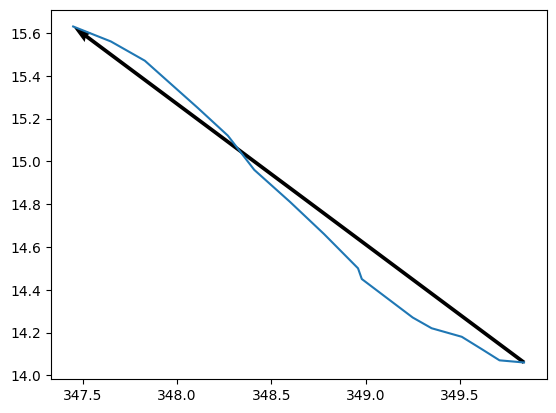

In [47]:
lon_smax = lons[i_smax]
lat_smax =  lats[i_smax]
lon_propa = lon_smax - lons[0]
lat_propa = lat_smax - lats[0]

plt.plot(lons[:i_smax+1], lats[:i_smax+1])

plt.quiver(lons[0], lats[0], lon_propa, lat_propa, scale=1, angles='xy', scale_units='xy')


In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]

t = len(times_3d_conv)

fig, ax = plt.subplots(figsize=(6, 6))

def animate(i):
    ax.clear()  # Clear the previous frame
    my_plot(ax, i)
    return ax

plt.close('all')

ani = animation.FuncAnimation(fig, animate, frames=t, blit=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

ValueError: 'y' values must be equally spaced

## Multi level (Hodograph)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def my_plot(ax, i):
    # ax = axs[i]
    colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)
    prec_cmap =  plt.get_cmap("nipy_spectral")
    w_cmap = plt.get_cmap("viridis")
    prec_cmap.set_bad(color=(1, 1, 1, 0))  # I think that's useless but unsure the way maps are superimposed
    cmap.set_bad(color=(1, 1, 1, 0))  # Transparent for NaNs

    le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
    le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}

    ### U & V Hodograph ###
    list_u = [hdlr.load_var(cs, "U", times_3d[i], z_idx = z, sel_dict = le_dico_court) for z in z_indices]
    list_v = [hdlr.load_var(cs, "V", times_3d[i], z_idx = z, sel_dict = le_dico_court) for z in z_indices]
    hodo_colors = ["blue", "orange", "green", "red", "purple"]

    new_lon = np.arange(slice_lon.start, slice_lon.stop, 2)
    new_lat = np.arange(slice_lat.start, slice_lat.stop, 2)    
    for u, v, La_Couleur_De_L_hodographe  in zip(list_u, list_v, hodo_colors):
        ## So what do we plot haha it depends on a radius ? square ? cloud_mask ? 
        # lon, lat = u["lon"].values, u["lat"].values

        u_clean, v_clean = u.U[0,0].interp(lon=new_lon, lat=new_lat), v.V[0,0].interp(lon=new_lon, lat=new_lat)
        lon, lat = u_clean["lon"], v_clean["lat"]
        Lon, Lat = np.meshgrid(lon, lat)

        u_mean, v_mean = np.mean(u_clean.values), np.mean(v_clean.values)
        
        ax.quiver(Lon, Lat, u_clean, v_clean, color=La_Couleur_De_L_hodographe, scale = 250) #20000/np.sqrt(u_mean**2 + v_mean**2)

        # print(f"{La_Couleur_De_L_hodographe} wind norm", np.sqrt(u_mean**2 + v_mean**2))
        # ax.quiver(lons_3d[i], lats_3d[i], u_mean, v_mean, color=La_Couleur_De_L_hodographe, scale = 200/np.sqrt(u_mean**2 + v_mean**2)) #, angles='xy', scale_units='xy'

    # plot prec (threshold, percentile based?)
    prec = hdlr.load_var(cs, "Prec", times_3d[i], sel_dict = le_dico_court).sel(le_dico_court).values
    prec_masked = np.ma.masked_less_equal(prec, 3)
    ax.imshow(prec_masked, origin = 'lower', cmap = prec_cmap, interpolation='nearest', alpha = 0.5, extent = extent)

    # plot central cloud with contour TODO a func
    seg = hdlr.load_seg(times_3d[i], sel_dict = le_dico_long)[0].values #.sel(le_dico_long)
    nan_mask = np.isnan(seg)
    output = np.full_like(seg, 0.5, dtype = float)
    output[nan_mask] = 0
    output[seg == iDCS] = 1
    ax.contour(output, levels=[0.75], colors='red', linewidths=0.5, linestyles='solid',extent = extent) #
    output[seg == iDCS] = 0.5
    ax.imshow(output, origin = 'lower', cmap=cmap, interpolation='nearest', alpha = 1, norm=mcolors.Normalize(vmin=0, vmax=1), extent = extent)

    ## trajectory, speed vector
    ax.plot(lons_3d[:i+1], lats_3d[:i+1], marker='o', color='grey', label='Trajectory Path', markersize=1)
    if i != start and i!= end-1 : 
        print("Le déplacement du centre de masse du système : ", np.sqrt(speed_lon_3d[i]**2 + speed_lat_3d[i]**2))
        ax.quiver(lons_3d[i], lats_3d[i], speed_lon_3d[i], speed_lat_3d[i], scale = 0.2/np.sqrt(speed_lon_3d[i]**2 + speed_lat_3d[i]**2)) #
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('auto')

    age_to_smax = int(100*np.round((times_3d[i] - st.settings["TIME_RANGE"][0] - start) / (time_smax - start), 2))
    ax.set_title(f"{iDCS}, age : {age_to_smax}%"+"\n"+f'{hdlr.i_t_to_nice_datetime(times_3d[i])}', loc='center')   

    return ax

# t = len(times_3d)
# # Initialize figure and axis
# fig, axs = plt.subplots(1,t, figsize=(6*t, 6))
# for i in range(t):
#     ax = axs[i]
#     my_plot(ax, i)


In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

times_3d_conv = [time for time in times_3d if time <= time_smax + st.settings["TIME_RANGE"][0]]

t = len(times_3d_conv)

fig, ax = plt.subplots(figsize=(6, 6))

def animate(i):
    ax.clear()  # Clear the previous frame
    my_plot(ax, i)
    return ax

plt.close('all')

ani = animation.FuncAnimation(fig, animate, frames=t, blit=False)

from IPython.display import HTML
HTML(ani.to_jshtml())

Le déplacement du centre de masse du système :  0.05700877125495303


In [69]:
# ani.save(f'iDCS_{iDCS}_and_shear.mp4', writer='ffmpeg', fps=0.5)

## most intence DCS

In [62]:
for iDCS in ft.DCS_number:
    print(iDCS.values)

    colors = [(1, 1, 1, 0), (0.8, 0.8, 0.8, 0.3), (0.5, 0.5, 0.5, 1)]  # RGBA for light grey to very light grey (with transparency)
    cmap = LinearSegmentedColormap.from_list("light_grey_scale", colors)
    prec_cmap =  plt.get_cmap("nipy_spectral")
    w_cmap = plt.get_cmap("viridis")
    prec_cmap.set_bad(color=(1, 1, 1, 0))  # I think that's useless but unsure the way maps are superimposed
    cmap.set_bad(color=(1, 1, 1, 0))  # Transparent for NaNs

    le_dico_long = {"latitude" : slice_lat, "longitude" : slice_lon}
    le_dico_court = {    "lat" : slice_lat,       "lon" : slice_lon}


    start, end, lons, lats, speeds, times, time_smax = get_frame_data(st, ft, iDCS)
    start, end, lons_3d, lats_3d, speeds_3d, times_3d, speed_lon_3d, speed_lat_3d = get_frame_data_3d(st, ft, iDCS)
    extent, slice_lon, slice_lat = get_extent_slices(lons_3d, lats_3d)

    dcs_prec = []
    for i in range(len(times)):
    ## plot prec (threshold, percentile based?)
        prec = hdlr.load_var(cs, "Prec", times[i]).sel(le_dico_court).values

        ## plot central cloud with contour TODO a func
        seg = hdlr.load_seg(times[i], sel_dict = le_dico_long)[0].sel(le_dico_long)
        nan_mask = np.isnan(seg)
        output = np.full_like(seg, 0.5, dtype = float)
        output[nan_mask] = 0
        output[seg == iDCS] = 1

        dcs_prec.append(np.sum(prec[seg== iDCS]))
    
    break


153377


In [63]:
dcs_prec

[43.61589, 0.43013, 4.4329224, 0.52423096]